(1600000,) (1600000, 5)


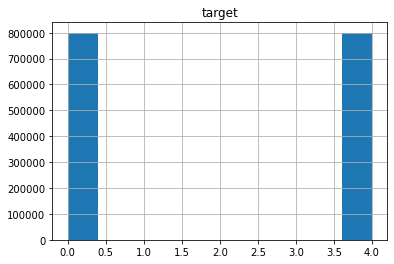

In [3]:
import pandas as pd


data = pd.read_csv('./dataset.csv', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])
data.hist(column='target')
outputs = data['target']
data = data.drop(columns=['target'])
print(outputs.shape, data.shape)

In [6]:
from sklearn.model_selection import train_test_split
x_train,y_test, x_label, y_label = train_test_split(data,outputs, test_size=0.80, random_state=42)
print(x_train.shape, y_test.shape, x_label.shape, y_label.shape)

(320000, 5) (1280000, 5) (320000,) (1280000,)


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier
from sklearn import svm
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', naive_bayes.MultinomialNB()),
])
pipeline.fit(x_train['text'], x_label)
print(pipeline.score(y_test['text'], y_label))

0.7659375


In [ ]:
print()